# Simple Recurrent Network (SRN / Elman Network) の実装

このノートブックでは、時系列データを扱うための基本的なリカレントニューラルネットワーク（RNN）の一つであるSimple Recurrent Network（SRN）、または提案者であるJeffrey Elman氏の名前にちなんでエルマンネットワークとも呼ばれるモデルの概念を学び、NumPyを使ってその主要な部分をスクラッチで実装します。

**参考論文:**
*   Elman, J. L. (1990). Finding structure in time. *Cognitive science*, 14(2), 179-211.

**このノートブックで学ぶこと:**
1.  時間情報を扱う上での従来のニューラルネットワークの課題。
2.  SRNのアーキテクチャと、コンテキストユニットを通じた「記憶」のメカニズム。
3.  SRNの順伝播の数式表現とNumPyによる実装。
4.  時系列データに対する逆伝播（Backpropagation Through Time - BPTT）の基本的な考え方。
5.  簡単な時系列予測タスク（Temporal XOR）でのSRNの学習。

**前提知識:**
*   基本的なPythonプログラミングとNumPyの操作。
*   多層パーセプトロン（MLP）の順伝播と逆伝播の理解（mlpのノートブック）。
*   活性化関数（Sigmoidなど）と損失関数（MSEなど）の知識。

## 1. 必要なライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 2. 時間情報を扱う上での課題
これまで扱ってきたMLPやCNNは、基本的には固定サイズの入力を一度に処理するフィードフォワード型のネットワークでした。しかし、自然言語、音声、株価、センサーデータなど、私たちの周りには時間的な順序や文脈が重要な意味を持つ**時系列データ**が数多く存在します。

Elman(1990)の論文では、従来のPDP(Parallel Distributed Processing)モデルが時間情報をどのように扱ってきたか、そしてその限界について議論しています。

### 2.1 時間情報を空間的な表現に変換するアプローチ (論文 "THE PROBLEM WITH TIME" より)
一つの単純なアプローチは、時間的なシーケンス全体を一つの長いベクトルとして空間的に展開し、それをMLPのようなネットワークの固定長の入力として与える方法です。例えば、長さ $T$ のシーケンスがあり、各時点での入力が $D$ 次元のベクトルであれば、$T \times D$ 次元の単一のベクトルとして扱います。

**問題点:**
1.  **固定長:** この方法では、入力シーケンスの長さをあらかじめ固定する必要があり、可変長のシーケンスを扱うのが困難です。言語のように文の長さが大きく異なるデータを扱うには不向きです。
2.  **時間的位置の曖昧さ:** 「時間的にずれた同じパターン」を、ネットワークが本質的に「似ている」と認識するのが難しくなります。空間的には異なる入力として扱われるため、これらの類似性を学習するには多くのデータと工夫が必要です。
    *   論文の例: `[01110000]` と `[00011100]` は同じパターンの時間シフトですが、ベクトルとしては大きく異なります。
3.  **長期依存性の困難さ:** シーケンスが長くなると、遠く離れた時点間の依存関係を捉えるのが非常に難しくなります。

これらの問題を解決するために、ネットワーク自身が過去の情報を何らかの形で「記憶」し、現在の処理に利用できるような仕組みが求められます。

## 3. Simple Recurrent Network (SRN) / Elman Network
Elman (1990) は、この「記憶」のメカニズムを導入するために、シンプルなリカレント（再帰的）接続を持つネットワーク構造を提案しました。これがSRN、またはエルマンネットワークです。


### 3.1 SRNのアーキテクチャ (論文 Figure 2 を参照)
SRNの基本的な構造は以下の通りです。
*   **入力層 ($x_t$):** 時刻 $t$ における外部からの入力。
*   **隠れ層 ($h_t$):** 入力層と、後述するコンテキスト層からの情報を受け取り、活性化関数を通して出力を計算します。
*   **出力層 ($y_t$):** 隠れ層からの情報を受け取り、最終的な出力を計算します（例: 次の時点の予測など）。
*   **コンテキスト層 ($c_t$):** これがSRNの核となる部分です。コンテキスト層は、**1つ前の時刻 $t-1$ の隠れ層の活性化状態 $h_{t-1}$ をコピーして保持**します。そして、このコンテキスト層の出力 $c_t = h_{t-1}$ が、次の時刻 $t$ での隠れ層の計算に入力の一部として使われます。

**情報の流れ:**
1.  時刻 $t$ で、入力 $x_t$ と前時刻の隠れ状態（コンテキスト $c_t = h_{t-1}$）が隠れ層に入力されます。
2.  隠れ層はこれらの情報から現在の状態 $h_t$ を計算します。
3.  $h_t$ は出力層に送られ、出力 $y_t$ が計算されます。
4.  同時に、$h_t$ は次の時刻 $t+1$ のためのコンテキスト $c_{t+1}$ としてコピー（保存）されます。

このように、隠れ層の状態がループ状にフィードバックされることで、ネットワークは過去の情報を保持し、時間的な文脈を考慮した処理が可能になります。コンテキストユニットの値は、ネットワークの「短期記憶」として機能します。

### 3.2 SRNの順伝播の数式表現
時刻 $t$ における各層の計算は以下のように表せます。

*   **隠れ層の活性化前入力 $net_{h,t}$:**
        $net_{h,t} = W_{xh} x_t + W_{hh} h_{t-1} + b_h$
    ここで、
    *   $x_t$: 時刻 $t$ での入力ベクトル
    *   $h_{t-1}$: 時刻 $t-1$ での隠れ層の活性化ベクトル（コンテキスト層の出力）
    *   $W_{xh}$: 入力層から隠れ層への重み行列
    *   $W_{hh}$: 前時刻の隠れ層（コンテキスト層）から現時刻の隠れ層への重み行列（リカレント重み）
    *   $b_h$: 隠れ層のバイアスベクトル

*   **隠れ層の活性化 $h_t$:**
    $h_t = \sigma_h (net_{h,t})$
    $\sigma_h$ は隠れ層の活性化関数（例: Sigmoid, Tanh, ReLU）。Elmanの原論文ではSigmoidが使われています。

*   **出力層の活性化前入力 $net_{y,t}$:**
    $net_{y,t} = W_{hy} h_t + b_y$
    ここで、
    *   $W_{hy}$: 隠れ層から出力層への重み行列
    *   $b_y$: 出力層のバイアスベクトル

*   **出力層の活性化 $y_t$ (予測値 $\hat{y}_t$):**
    $\hat{y}_t = \sigma_y (net_{y,t})$
    $\sigma_y$ は出力層の活性化関数（タスクによる。回帰なら恒等関数、二値分類ならSigmoid、多クラス分類ならSoftmaxなど）。Elmanの論文の予測タスクでは、出力も入力と同様の形式（例: One-hotベクトル）で、活性化関数としてSigmoidが使われることが多いです。

*   **コンテキストの更新:**
    $c_{t+1} = h_t$ (Elman Networkの場合、論文Figure 2では固定重み1.0でのコピーと記載)

時刻 $t=0$ における初期の隠れ状態 $h_{-1}$ (または $h_0$) は、通常ゼロベクトルで初期化されます。

## 4. NumPyによるSRNの主要コンポーネント実装

### 4.1 活性化関数 (再掲)
ここでは隠れ層と出力層の両方にSigmoid関数を使用します。

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

### 4.2 パラメータの初期化
SRNの学習可能なパラメータは、$W_{xh}, W_{hh}, b_h, W_{hy}, b_y$ です。

In [3]:
def initialize_srn_parameters(input_size, hidden_size, output_size):
    '''SRNの重みとバイアスの初期化'''
    np.random.seed(42)

    # 入力 -> 隠れ層
    W_xh = np.random.randn(input_size, hidden_size) * 0.01
    # 隠れ層（前時刻） -> 隠れ層（現在時刻）
    W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
    b_h = np.zeros((1, hidden_size))

    # 隠れ層 -> 出力
    W_hy = np.random.randn(hidden_size, output_size) * 0.01
    b_y = np.zeros((1, output_size))

    parameters = {
        'W_xh': W_xh,
        'W_hh': W_hh,
        'b_h': b_h,
        'W_hy': W_hy,
        'b_y': b_y
    }
    return parameters

### 4.3 SRNの順伝播ステップ (1タイムステップ分)

1つのタイムステップにおけるSRNの順伝播を計算する関数を実装します。
この関数は、現在の入力 $x_t$ と前時刻の隠れ状態 $h_{prev}$ を受け取り、現在の出力 $\hat{y}_t$ と現在の隠れ状態 $h_t$ を返します。

In [4]:
def srn_forward_step(xt, h_prev, parameters, hidden_activation_fn = sigmoid, output_activation_fn = sigmoid):
    '''
    SRNの1ステップの順伝播計算
    parameters:
        xt: 時刻tの入力（1, hidden_size）
        h_prev: 時刻t-1の隠れ状態（1, hidden_size）
        parameters: 重みとバイアス
        hidden_activation_fn: 隠れ層の活性化関数
        output_activation_fn: 出力層の活性化関数
    returns:
        tupple: (y_hat_t, h_t, cache_t)
            y_hat_t: 時刻tの予測出力
            h_t: 時刻tの隠れ状態
            cache_t: キャッシュ（逆伝播用）
    '''
    W_xh, W_hh, b_h = parameters['W_xh'], parameters['W_hh'], parameters['b_h']
    W_hy, b_y = parameters['W_hy'], parameters['b_y']

    # 隠れ層の計算
    # net_h_t = xt @ W_xh + h_prev @ W_hh + b_h
    # 入力xtが(input_size,)の場合や，(1, input_size)の場合を考慮
    if xt.ndim == 1:
        xt = xt.reshape(1, -1)
    if h_prev.ndim == 1:
        h_prev = h_prev.reshape(1, -1)

    net_h_t = np.dot(xt, W_xh) + np.dot(h_prev, W_hh) + b_h
    h_t = hidden_activation_fn(net_h_t)

    # 出力層の計算
    net_y_t = np.dot(h_t, W_hy) + b_y
    y_hat_t = output_activation_fn(net_y_t)

    cache_t = {
        'xt': xt,
        'h_prev': h_prev,
        'net_h_t': net_h_t,
        'h_t': h_t,
        'net_y_t': net_y_t,
        'y_hat_t': y_hat_t
    }

    return y_hat_t, h_t, cache_t

In [5]:
# テスト
input_dim_srn = 1
hidden_dim_srn = 2
output_dim_srn = 1
srn_params = initialize_srn_parameters(input_dim_srn, hidden_dim_srn, output_dim_srn)

xt_test = np.array([[0.5]]) # 時刻tの入力
h_prev_test = np.zeros((1, hidden_dim_srn)) # 前時刻の隠れ状態 (初期はゼロ)

y_hat_t_test, h_t_test, cache_t_test = srn_forward_step(xt_test, h_prev_test, srn_params)
print("xt_test:\n", xt_test)
print("h_prev_test:\n", h_prev_test)
print("y_hat_t_test (予測出力):\n", y_hat_t_test)
print("h_t_test (現隠れ状態):\n", h_t_test)

xt_test:
 [[0.5]]
h_prev_test:
 [[0. 0.]]
y_hat_t_test (予測出力):
 [[0.5029354]]
h_t_test (現隠れ状態):
 [[0.50062089 0.49982717]]


### 4.4 シーケンス全体の順伝播

入力シーケンス全体に対して順伝播を行います。各タイムステップで計算された隠れ状態を次のステップに渡し、各ステップの出力とキャッシュを保存します。

In [6]:
def srn_forward(X_sequence, h0, parameters,
                hidden_activation_fn=sigmoid, output_activation_fn=sigmoid):
    '''
    入力シーケンス全体に対するSRNの順伝播
    parameters:
        X_sequence: 入力シーケンス（T, input_size）, Tはシーケンスの長さ
        h0: 初期隠れ状態（1, hidden_size）
        parameters: 重みとバイアス
    returns:
        tuple(Y_hat_sequence, H_sequence, Caches_sequence)
            Y_hat_sequence: 各時刻の予測出力のシーケンス（T, output_size）
            H_sequence: 各時刻の隠れ状態のシーケンス（T+1, hidden_size）, H[0]=h0
            Caches_sequence: 各時刻のキャッシュのリスト
    '''
    T, input_size = X_sequence.shape
    hidden_size = parameters['W_hh'].shape[0]
    output_size = parameters['b_y'].shape[1]

    Y_hat_sequence = np.zeros((T, output_size))
    H_sequence = np.zeros((T + 1, hidden_size)) # H[0] = h0, H[t+1] = h_t
    Caches_sequence = []

    h_prev = h0
    H_sequence[0, :] = h_prev.flatten() # H_sequence[0]に初期隠れ状態を設定

    for t in range(T):
        xt = X_sequence[t, :].reshape(1, -1) # 現在の入力を(1, input_size)に変形
        y_hat_t, h_t, cache_t = srn_forward_step(xt,
                                                 h_prev,
                                                 parameters,
                                                 hidden_activation_fn,
                                                    output_activation_fn)
        Y_hat_sequence[t, :] = y_hat_t.flatten()
        H_sequence[t + 1, :] = h_t.flatten()
        Caches_sequence.append(cache_t)

        h_prev = h_t  # 次のステップのために現在の隠れ状態を保存
        
    return Y_hat_sequence, H_sequence, Caches_sequence


In [7]:
# テスト
X_seq_test = np.array([[0.1],[0.5],[0.9]]) # T=3, input_size=1
h0_test = np.zeros((1, hidden_dim_srn))
Y_hat_seq, H_seq, Caches_seq = srn_forward(X_seq_test, h0_test, srn_params)

print("入力シーケンス X_seq_test:\n", X_seq_test)
print("初期隠れ状態 h0_test:\n", h0_test)
print("\n予測出力シーケンス Y_hat_seq:\n", Y_hat_seq)
print("隠れ状態シーケンス H_seq (H[0]が初期状態):\n", H_seq)
# print("\nキャッシュ (最初のタイムステップ):\n", Caches_seq[0]

入力シーケンス X_seq_test:
 [[0.1]
 [0.5]
 [0.9]]
初期隠れ状態 h0_test:
 [[0. 0.]]

予測出力シーケンス Y_hat_seq:
 [[0.5029337 ]
 [0.50294053]
 [0.50294223]]
隠れ状態シーケンス H_seq (H[0]が初期状態):
 [[0.         0.        ]
 [0.50012418 0.49996543]
 [0.50113803 0.50143877]
 [0.50163552 0.50130351]]


### 4.5 損失関数 (再掲)
回帰タスクや、論文のような次のビット予測タスクでは平均二乗誤差(MSE)が使えます。

In [8]:
def mean_squared_error_sequence(Y_true_sequence, Y_hat_sequence):
    """ シーケンス全体の平均二乗誤差 """
    # Y_true_sequence, Y_hat_sequence は (T, output_size)
    return np.mean((Y_true_sequence - Y_hat_sequence)**2)

### 4.6 逆伝播 (Backpropagation Through Time - BPTT) の概念

SRNの学習では、誤差を時間に沿って逆伝播させるBPTTが用いられます。
これは、シーケンス全体を展開したフィードフォワードネットワークに対する通常のバックプロパゲーションと考えることができますが、リカレント重み $W_{hh}$ は全てのタイムステップで共有されている点が異なります。

**BPTTの基本的な考え方:**
1.  シーケンス全体の損失 $L = \sum_{t=1}^{T} L_t$ を計算します。$L_t$ は時刻 $t$ での損失（例: $\frac{1}{2} \| y_t - \hat{y}_t \|^2$）。
2.  出力層から隠れ層へ、そして隠れ層から入力層へと、各タイムステップごとに逆向きに勾配を計算していきます。
3.  **重要な点:** 時刻 $t$ の隠れ層の勾配 $\frac{\partial L}{\partial h_t}$ は、2つの経路から寄与を受けます。
    *   時刻 $t$ の出力層からの寄与: $\frac{\partial L_t}{\partial h_t}$
    *   時刻 $t+1$ の隠れ層からの寄与（リカレント接続を通じたもの）: $\frac{\partial L}{\partial h_{t+1}} \frac{\partial h_{t+1}}{\partial h_t}$
4.  各パラメータ ($W_{xh}, W_{hh}, b_h, W_{hy}, b_y$) の勾配は、シーケンス全体の各タイムステップで計算された勾配を合計（または平均）したものになります。特に $W_{hh}$ の勾配は、全ての時間ステップにわたる影響を考慮して蓄積されます。

**1ステップ分の勾配計算 (時刻 $t$ での出力 $y_t$ に関する損失 $L_t$ のみ考慮する場合の簡略化):**
完全なBPTTは複雑なので、ここではまず、各タイムステップ $t$ での損失 $L_t$ が、その時刻のパラメータにどのように影響するかだけを考えます（つまり、未来の損失からの勾配伝播は一旦無視します）。これはTruncated BPTTの最も単純なケース (展開ステップ1) に近いです。Elman(1990)の論文では、学習は各タイムステップで行われ、コンテキストは前の状態を引き継ぐが、勾配計算は現在のステップのエラーのみに基づいて行われるように読めます (p.182 "Depending upon the task, there may or may not be a learning phase in this time cycle. If so, the output is compared with a teacher input, and back propagation of error ... is used to adjust connection strengths incrementally.")。

以下は、時刻 $t$ の損失 $L_t$ に関する、その時刻の計算に関与したパラメータの勾配です。
$\frac{\partial L_t}{\partial \text{param}}$

*   **出力層の重み $W_{hy}, b_y$:**
    *   $dnet_{y,t} = \frac{\partial L_t}{\partial \hat{y}_t} \frac{\partial \hat{y}_t}{\partial net_{y,t}}$  (例: MSEなら $(\hat{y}_t - y_t) \odot \sigma_y'(net_{y,t})$)
    *   $\frac{\partial L_t}{\partial W_{hy}} = h_t^T \cdot dnet_{y,t}$
    *   $\frac{\partial L_t}{\partial b_y} = dnet_{y,t}$

*   **隠れ層の重み $W_{xh}, W_{hh}, b_h$:**
    *   $dh_t = \frac{\partial L_t}{\partial net_{y,t}} W_{hy}^T$ (出力層から隠れ層の活性化への勾配)
    *   $dnet_{h,t} = dh_t \odot \sigma_h'(net_{h,t})$ (隠れ層の活性化前から活性化への勾配)
    *   $\frac{\partial L_t}{\partial W_{xh}} = x_t^T \cdot dnet_{h,t}$
    *   $\frac{\partial L_t}{\partial W_{hh}} = h_{t-1}^T \cdot dnet_{h,t}$
    *   $\frac{\partial L_t}{\partial b_h} = dnet_{h,t}$

**完全なBPTTでは、$\frac{\partial L}{\partial h_t}$ を計算し、これを $dh_{next}$ として時刻 $t-1$ に伝播させる必要があります。**
$\frac{\partial L}{\partial h_t} = \frac{\partial L_t}{\partial h_t} + \frac{\partial L}{\partial h_{t+1}} \frac{\partial h_{t+1}}{\partial h_t}$
$\frac{\partial h_{t+1}}{\partial h_t} = \frac{\partial \sigma_h(W_{xh}x_{t+1} + W_{hh}h_t + b_h)}{\partial h_t} = \sigma_h'(net_{h, t+1}) W_{hh}^T$

今回は、Elman論文の逐次的な学習の記述に基づき、**各タイムステップで誤差を計算し、その誤差のみを使って即座にパラメータを更新する**というオンライン学習的なアプローチをまず実装してみます。これはBPTTを時間方向に展開せず、現在のエラーのみで学習する単純な方法です。

In [9]:
# 1ステップ分のバックプロパゲーション
def srn_backward_step_simplified(dy_hat_t, cache_t, parameters,
                                 hidden_activation_derivative_fn = sigmoid_derivative):
    '''
    SRNの1ステップの逆伝播計算（時刻tの誤差のみ考慮）
    parameters:
        dy_hat_t: 時刻tの出力層の活性化後の誤差勾配（dL/dy_hat_t）
        cache_t: 時刻tの順伝播のキャッシュ
        parameters: 重み
    returns:
        dict: 時刻tの誤差に対する各パラメータの勾配
        np.array: 時刻tの誤差に対するh_prevの勾配（dL_t/dh_prev）
    '''
    xt, h_prev, h_t, net_h_t, y_hat_t, net_y_t = (
        cache_t['xt'], cache_t['h_prev'], cache_t['h_t'],
        cache_t['net_h_t'], cache_t['y_hat_t'], cache_t['net_y_t']
    )
    W_hy = parameters['W_hy']
    W_hh = parameters['W_hh']

    # 出力層の勾配
    d_net_y_t = dy_hat_t * sigmoid_derivative(net_y_t)
    dW_hy = np.dot(h_t.T, d_net_y_t)
    db_y = np.sum(d_net_y_t, axis=0, keepdims=True)

    # 隠れ層の勾配
    dh_t = np.dot(d_net_y_t, W_hy.T)
    d_net_h_t = dh_t * hidden_activation_derivative_fn(net_h_t)

    dW_xh = np.dot(xt.T, d_net_h_t)
    dW_hh = np.dot(h_prev.T, d_net_h_t)
    db_h = np.sum(d_net_h_t, axis=0, keepdims=True)

    # このノートブックでは、dh_prevは実際には使われないが、BPTTの概念として計算しておく
    dh_prev_for_bptt = np.dot(d_net_h_t, W_hh.T) 
    
    grads_t = {"W_xh": dW_xh, "W_hh": dW_hh, "b_h": db_h, 
               "W_hy": dW_hy, "b_y": db_y}
    
    return grads_t # dh_prev_for_bpttは返さない

### 4.7 パラメータ更新 (再掲)

In [10]:
def update_srn_parameters(parameters, grads, learning_rate):
    """ SGDでSRNのパラメータを更新 """
    for key in parameters.keys():
        parameters[key] -= learning_rate * grads[key]
    return parameters

## 5. 実験: Temporal XOR問題

Elman(1990)の論文では、XOR問題の時間的バージョンでSRNの能力をデモンストレーションしています。
入力は1ビットずつシーケンシャルに与えられ、ネットワークは次のビットを予測するタスクを学習します。

**Temporal XORのルール:**
入力シーケンス: `b1, b2, out, b3, b4, out, ...`
ここで `out = b1 XOR b2`。
ネットワークは、各時点で次のビットを予測します。
*   `b1` を見た後、`b2` を予測 (50%の確率)
*   `b2` を見た後、`out = b1 XOR b2` を予測 (100%の確率で予測可能であるべき)
*   `out` を見た後、次の `b3` を予測 (50%の確率)

### 5.1 データセットの生成

In [ ]:
def generate_temporal_xor_data(num_sequences=100, noise=0.0):
    """
    Temporal XORのシーケンスデータを生成する。
    各シーケンスは [b1, b2, b1^b2, b3, b4, b3^b4, ...] となる。
    入力Xはt番目のビット、出力Yはt+1番目のビットを予測。
    Args:
        num_sequences: 生成するXORパターンの繰り返し数
    Returns:
        tuple (X_data, Y_data)
        X_data (np.array): (N, 1) 入力ビットのシーケンス
        Y_data (np.array): (N, 1) 予測すべき次のビットのシーケンス
    """
    full_sequence = []
    for _ in range(num_sequences):
        b1 = np.random.randint(0, 2)
        b2 = np.random.randint(0, 2)
        out = b1 ^ b2
        full_sequence.extend([b1, b2, out])
    
    full_sequence = np.array(full_sequence, dtype=np.float32)
    
    # 入力Xはシーケンスそのもの (ただし最後の要素を除く)
    # 出力Yは1ステップシフトしたシーケンス (最初の要素を除く)
    X_data = full_sequence[:-1].reshape(-1, 1)
    Y_data = full_sequence[1:].reshape(-1, 1)
    
    if noise > 0: # オプションでノイズ付加
        X_data += np.random.normal(0, noise, X_data.shape)
        # Y_data はノイズなし（ターゲットなので）
        
    return X_data, Y_data

In [12]:
# データ生成
X_temporal_xor, Y_temporal_xor = generate_temporal_xor_data(num_sequences=1000)
print("Temporal XORデータ X shape:", X_temporal_xor.shape) # (2999, 1)
print("Temporal XORデータ Y shape:", Y_temporal_xor.shape) # (2999, 1)
print("最初の数サンプル:")
for i in range(9):
    print(f"X[{i}]={X_temporal_xor[i,0]}, Y[{i}] (target for X[{i}])={Y_temporal_xor[i,0]}")

# 例: X[0]=b1, Y[0]=b2
#     X[1]=b2, Y[1]=out
#     X[2]=out, Y[2]=b3 (次のXORの1番目のビット)

Temporal XORデータ X shape: (2999, 1)
Temporal XORデータ Y shape: (2999, 1)
最初の数サンプル:
X[0]=1.0, Y[0] (target for X[0])=0.0
X[1]=0.0, Y[1] (target for X[1])=1.0
X[2]=1.0, Y[2] (target for X[2])=1.0
X[3]=1.0, Y[3] (target for X[3])=1.0
X[4]=1.0, Y[4] (target for X[4])=0.0
X[5]=0.0, Y[5] (target for X[5])=1.0
X[6]=1.0, Y[6] (target for X[6])=1.0
X[7]=1.0, Y[7] (target for X[7])=0.0
X[8]=0.0, Y[8] (target for X[8])=1.0


### 5.2 SRNのオンライン学習ループ (Temporal XOR)

Elman論文に倣い、各タイムステップで誤差を計算し、即座にパラメータを更新するオンライン学習的なアプローチで学習します。
シーケンス全体を何回か繰り返して学習（エポック）します。

In [13]:
def train_srn_temporal_xor(X_seq, Y_seq, hidden_size, num_epochs=100, learning_rate=0.1, print_cost_every_epoch=10):
    input_s = X_seq.shape[1]
    output_s = Y_seq.shape[1]
    sequence_len = X_seq.shape[0]
    
    parameters = initialize_srn_parameters(input_s, hidden_size, output_s)
    
    # 初期隠れ状態
    h_prev = np.zeros((1, hidden_size))
    
    costs_per_epoch = []
    
    for epoch in range(num_epochs + 1):
        epoch_cost = 0
        h_prev_epoch_start = np.zeros((1, hidden_size)) # エポック開始時に隠れ状態リセット
        h_prev_current_step = h_prev_epoch_start.copy()

        predictions_epoch = [] # このエポックの予測を保存

        for t in range(sequence_len):
            xt = X_seq[t].reshape(1, -1)
            yt_true = Y_seq[t].reshape(1, -1)
            
            # 順伝播 (1ステップ)
            yt_hat, ht_current, cache_t = srn_forward_step(xt, h_prev_current_step, parameters)
            predictions_epoch.append(yt_hat.item())
            
            # 損失 (このタイムステップのMSEの主要部)
            error_t = yt_hat - yt_true # dL/dy_hat_t for L = 0.5 * (y_hat - y_true)^2
            cost_t = 0.5 * np.sum(error_t**2)
            epoch_cost += cost_t
            
            # 逆伝播 (1ステップ、オンライン版)
            grads_t = srn_backward_step_simplified(error_t, cache_t, parameters)
            
            # パラメータ更新
            parameters = update_srn_parameters(parameters, grads_t, learning_rate)
            
            # 次のステップのために隠れ状態を更新
            h_prev_current_step = ht_current
            
        avg_epoch_cost = epoch_cost / sequence_len
        costs_per_epoch.append(avg_epoch_cost)
        
        if epoch % print_cost_every_epoch == 0:
            print(f"Epoch {epoch}, Average Cost (MSE-like): {avg_epoch_cost:.6f}")
            # 予測が正しいかどうかの簡単なチェック (3ステップ目がXOR結果)
            correct_xor_predictions = 0
            total_xor_ops = 0
            for i in range(2, sequence_len, 3): # 3ステップ目がXORの出力のはず
                # X[i-2] が b1, X[i-1] が b2, Y[i-1] が out = b1^b2
                # ネットワークは Y_hat[i-1] で out を予測する
                b1 = X_seq[i-2, 0]
                b2 = X_seq[i-1, 0]
                expected_xor_out = b1_int ^ b2_int if (b1_int:=int(b1)) == b1 and (b2_int:=int(b2)) == b2 else -1 # 整数のみ
                
                if expected_xor_out != -1:
                    predicted_out_for_b2 = predictions_epoch[i-1] # Y_hat[i-1] (X[i-1]=b2の時の予測)
                    total_xor_ops +=1
                    if np.round(predicted_out_for_b2) == expected_xor_out:
                        correct_xor_predictions +=1
            if total_xor_ops > 0:
                 print(f"  XOR prediction accuracy on this epoch (approx): {100*correct_xor_predictions/total_xor_ops:.2f}%")


    return parameters, costs_per_epoch


SRN 学習開始 (Temporal XORデータ, 2 hidden units)...
Epoch 0, Average Cost (MSE-like): 0.125271
  XOR prediction accuracy on this epoch (approx): 51.05%
Epoch 120, Average Cost (MSE-like): 0.125023
  XOR prediction accuracy on this epoch (approx): 53.05%
Epoch 240, Average Cost (MSE-like): 0.123794
  XOR prediction accuracy on this epoch (approx): 54.95%
Epoch 360, Average Cost (MSE-like): 0.114912
  XOR prediction accuracy on this epoch (approx): 91.09%
Epoch 480, Average Cost (MSE-like): 0.113699
  XOR prediction accuracy on this epoch (approx): 92.29%
Epoch 600, Average Cost (MSE-like): 0.113272
  XOR prediction accuracy on this epoch (approx): 92.69%
Epoch 720, Average Cost (MSE-like): 0.114235
  XOR prediction accuracy on this epoch (approx): 88.09%
Epoch 840, Average Cost (MSE-like): 0.114434
  XOR prediction accuracy on this epoch (approx): 89.39%
Epoch 960, Average Cost (MSE-like): 0.115490
  XOR prediction accuracy on this epoch (approx): 85.59%
Epoch 1080, Average Cost (MSE-like): 

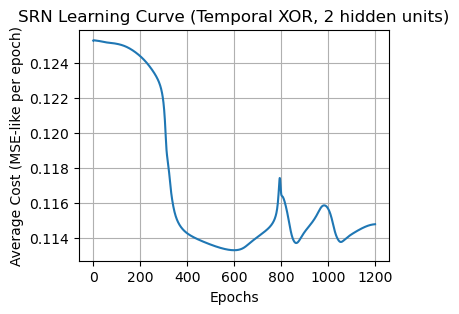

In [17]:
# 学習の実行
hidden_dim_srn_xor = 2 # Elman論文のXORでは2隠れユニット
epochs_xor = 1200 # 論文では600パスなど
lr_xor = 0.05

print(f"\nSRN 学習開始 (Temporal XORデータ, {hidden_dim_srn_xor} hidden units)...")
trained_params_srn_xor, costs_srn_xor = train_srn_temporal_xor(
    X_temporal_xor, Y_temporal_xor, 
    hidden_size=hidden_dim_srn_xor, 
    num_epochs=epochs_xor, 
    learning_rate=lr_xor,
    print_cost_every_epoch = epochs_xor // 10
)

# 学習曲線のプロット
plt.figure(figsize=(4,3))
plt.plot(costs_srn_xor)
plt.xlabel("Epochs")
plt.ylabel("Average Cost (MSE-like per epoch)")
plt.title(f"SRN Learning Curve (Temporal XOR, {hidden_dim_srn_xor} hidden units)")
plt.grid(True)
plt.show()


予測可能ポイント(XOR出力)での平均RMSE: 0.3895
予測困難ポイント1(b2)での平均RMSE: 0.5204
予測困難ポイント2(次のb1)での平均RMSE: 0.5158


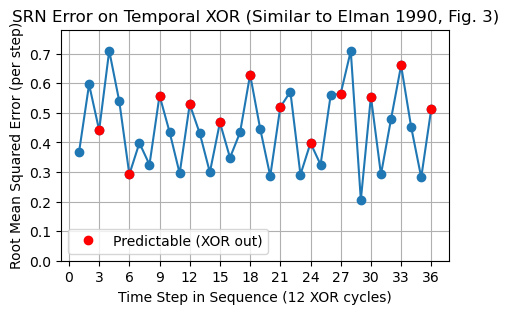

In [18]:
# 学習済みモデルで予測シーケンスを生成
Y_hat_final_xor, _, _ = srn_forward(X_temporal_xor, np.zeros((1, hidden_dim_srn_xor)), trained_params_srn_xor)

# 論文Figure 3のようなエラープロット (3ステップごとのRMSE)
errors_at_predictable_points = []
errors_at_unpredictable_points1 = [] # b1を見た後b2を予測
errors_at_unpredictable_points2 = [] # outを見た後b_next1を予測

for t in range(len(Y_temporal_xor)):
    true_val = Y_temporal_xor[t,0]
    pred_val = Y_hat_final_xor[t,0]
    error_sq = (true_val - pred_val)**2
    
    # t は Y_temporal_xor のインデックス。
    # Y_temporal_xor[t] は X_temporal_xor[t] の次のビット
    # t % 3 == 0  -> X[t]はb1, Y[t]はb2 (予測困難)
    # t % 3 == 1  -> X[t]はb2, Y[t]はout (予測可能)
    # t % 3 == 2  -> X[t]はout,Y[t]はb_next1 (予測困難)
    
    if t % 3 == 0: # b2を予測
        errors_at_unpredictable_points1.append(error_sq)
    elif t % 3 == 1: # out = b1^b2 を予測
        errors_at_predictable_points.append(error_sq)
    elif t % 3 == 2: # 次のb1を予測
        errors_at_unpredictable_points2.append(error_sq)

print(f"\n予測可能ポイント(XOR出力)での平均RMSE: {np.sqrt(np.mean(errors_at_predictable_points)):.4f}")
print(f"予測困難ポイント1(b2)での平均RMSE: {np.sqrt(np.mean(errors_at_unpredictable_points1)):.4f}")
print(f"予測困難ポイント2(次のb1)での平均RMSE: {np.sqrt(np.mean(errors_at_unpredictable_points2)):.4f}")

# 論文Figure 3に似たプロット (12サイクル分のRMSE)
# 1サイクル = 3ビット (b1, b2, out)
# 12サイクル = 36ビット
if len(Y_temporal_xor) >= 36:
    errors_per_step = (Y_temporal_xor[:36,0] - Y_hat_final_xor[:36,0])**2
    rmse_per_step = np.sqrt(errors_per_step)
    
    plt.figure(figsize=(5,3))
    plt.plot(range(1,37), rmse_per_step, marker='o', linestyle='-')
    # 3ステップごとにエラーが小さくなるはずのポイントに印
    predictable_indices = [i for i in range(2,36,3)] # 2, 5, 8, ... (0-indexedなら 1, 4, 7)
    plt.plot(np.array(predictable_indices)+1, rmse_per_step[predictable_indices], 'ro', label='Predictable (XOR out)')

    plt.xticks(np.arange(0, 37, 3))
    plt.xlabel("Time Step in Sequence (12 XOR cycles)")
    plt.ylabel("Root Mean Squared Error (per step)")
    plt.title("SRN Error on Temporal XOR (Similar to Elman 1990, Fig. 3)")
    plt.grid(True)
    plt.legend()
    plt.ylim(0, np.max(rmse_per_step)*1.1 if np.max(rmse_per_step) > 0 else 1.0)
    plt.show()

## 6. 考察

*   **SRNの能力:**
    *   単純なTemporal XOR問題において、SRNは時間的な依存関係を学習し、予測可能なポイント（XORの出力）では比較的低い誤差で次のビットを予測できることが期待されます。Elman(1990)のFigure 3では、この予測可能なタイミングで誤差が周期的に低下する様子が示されています。
    *   隠れ層の活性化（コンテキスト層を通じてフィードバックされる）が、過去の入力の情報を保持し、現在の予測に利用される「短期記憶」として機能します。論文では、この隠れ層の活性化パターンが入力シーケンスの構造（例: 単語のカテゴリなど）を反映する内部表現を形成することが示されています。

*   **BPTTの重要性と複雑性:**
    *   今回の実装では、各タイムステップの誤差のみに基づいてパラメータを更新するオンライン学習的なアプローチ（Truncated BPTTで展開ステップ1に相当、またはElman論文の記述に近い逐次更新）を試みました。
    *   より正確に長期的な依存関係を学習するためには、シーケンス全体または一定期間（Truncation Depth）にわたって誤差を逆伝播させる完全なBPTTが必要です。しかし、BPTTは計算コストが高く、また勾配消失・爆発の問題も発生しやすいため、実装と学習がより複雑になります。
    *   LSTMやGRUといったゲート付きRNNは、このBPTTにおける勾配消失・爆発問題を緩和するために設計されました。

*   **このスクラッチ実装から得られる学び:**
    *   リカレント接続がどのようにしてネットワークに「状態」や「記憶」の概念をもたらすか。
    *   時間軸に沿った情報処理と、その学習の難しさ（特に長期依存性）。
    *   より高度なRNNアーキテクチャ（LSTM, GRU）や、Transformerのような非RNNベースのシーケンスモデルの必要性への理解。

このSRNの実装は、リカレントニューラルネットワークの基本的な動作原理を理解するための第一歩です。次の段階では、LSTMやGRUといったより強力なRNNセルや、完全なBPTTの概念、そしてPyTorchのようなフレームワークでの効率的な実装に進むことになるでしょう。